# GANによる画像生成のメカニズムとDCGANの実装

5章で学ぶこと
- DCGAN
- Self-Attention GAN  

- Generatorの構造
- Discriminatorの構造
- GANの損失関数と学習の流れ
- DCGANのネットワークを実装

## フォルダ準備
MNIST  
scikit-learnから取得する  
6章用のデータも一緒に用意

In [1]:
import os
from sklearn.datasets import fetch_openml
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data_dir = "../../datasets/ptca_datasets/chapter5"
img_78_path = os.path.join(data_dir, "img_78")
test_path = os.path.join(data_dir, "test")

for path in [data_dir, img_78_path, test_path]:
    if not os.path.exists(path):
        os.mkdir(path)

In [3]:
# MNISTの手書き数字画像をダウンロードし読み込みます（2分ほど時間がかかります）
mnist = fetch_openml('mnist_784', version=1, data_home=data_dir)  

# データの取り出し
X = mnist.data
y = mnist.target

この画像データのラベルは5です


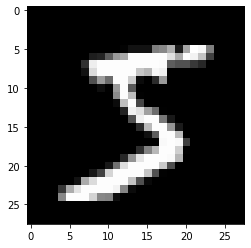

In [4]:
# ロードできてるか確認
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))

In [5]:
# 時間短縮のため，7，8のみを扱うGANを作りたい．
# MNISTから数字7、8の画像だけフォルダ「img_78」に(64,64)PIL画像として保存していく
count7=0
count8=0
max_num=200  # 画像は200枚ずつ作成する

for i in range(len(X)):
    
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path=os.path.join(img_78_path, f"img_7_{count7}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count7+=1 
    
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path=os.path.join(img_78_path, f"img_8_{count8}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count8+=1 

In [8]:
# 6章用テストデータも作成
count2=0
count7=0
count8=0
max_num=5

for i in range(2244,len(X)):
    
    # 画像2の作成
    if (y[i] is "2") and (count2<max_num):
        file_path=os.path.join(test_path, f"img_2_{count2}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count2+=1
    
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path=os.path.join(test_path, f"img_7_{count7}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count7+=1 
    
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path=os.path.join(test_path, f"img_8_{count8}.jpg")
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count8+=1 

## Generatorのメカニズム
教師データを手がかりとし，乱数を入力して手書き数字っぽい画像を出力する  
  
入力乱数をnn.ConvTranspose2d, 転置畳み込みによって画像に拡大  
転置畳み込みでは，入力をカーネルフィルタにかけるので複雑な拡大処理を実現  
なお，F.interpolateも拡大の機能を持つが，こちらはカーネルを使っていない  


## Generatorの実装
DCGAN(Deep Comvolution Generative Adversarial Network)を実装  
DCGANは転置畳み込み, バッチNorm, ReLUを1セットにしたlayerを4回繰り返す  
z_dimが乱数の次元で，所望の多様性を持つ次元を確保させる

In [6]:
import torch
from torch import nn, optim
from torch.utils import data
from torchvision import models, transforms
from IPython.display import clear_output
import time

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True) # ReLUの省メモリ化
        )
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            # 白黒画像なので出力チャネルは1つだけ
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

実装したGで画像を生成してみると，砂嵐のような画像が出力される  
Gの結合パラメータを学習させることで手書き数字画像を生成するようになる

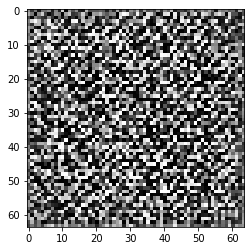

In [8]:
G = Generator()

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1) # (1,20, 1, 1)

fake_images = G(input_z) # Gによる画像生成 (1, 1, 64, 64)
img_transposed = fake_images[0][0].detach().numpy() # (0, 0)に画像

plt.imshow(img_transposed, 'gray')

## Discriminatorのメカニズム
DはGの損失関数という立ち位置  
- 生成画像をいちいち人出でラベルづけするのは大変
- 初期状態では人から見たら全部だめなので，何が良いのか教えられない
  
DはNNによる画像分類を行い，本物なら0，偽物なら1を出力する  
生成された画像に加えて，教師データとして本物の画像も判別させる  
  
このように，未熟なDとGが互いに騙し合いながら学習を進めることで，最終的に本物のような画像を生成するのが，GAN(Generative Adversarial Network)

## Discriminatorの実装
ただの画像分類NNで，本物なら0偽物なら1を出力するためCNNを使う  
入力された値が負の値の時入力値にある係数をかけた負値を出力するLeakyReLUを活性化関数に使用する

In [9]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            # 白黒画像なので入力チャネルは1つだけ
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

実装したDでGの出力画像を判別させてみる  
だいたい0.5くらいの出力が出て，まだ判別がちゃんとできないことがわかる

In [10]:
D = Discriminator()
d_out = D(fake_images)
print(nn.Sigmoid()(d_out))

tensor([[[[0.5061]]]], grad_fn=<SigmoidBackward>)


# DCGANの損失関数，学習，生成の実装

## GANの損失関数
まずは$D$の損失関数について考える  
入力画像$x$に対する識別器$D$の出力は$y=D(x)$と表される  
教師ラベル$l\in\{0,1\}$とすると，$D$の出力が正答かどうかは$y^l(1-y)^{1-l}$  
($y=l$なら1, $y\neq l$なら0, $y$の値が連続値でもそれぞれに近く)  
これは$D$の出す結果が正しい確率と考えられる．
  
ミニバッチのデータ数$M$個に対する$D$の結果が全て正しくなる同時確率は
$$\prod^M_{i=1} y^l_i(1-y_i)^{1-l_i}$$
この確率の対数をとり，最小化のためマイナスをつけると
$$-\sum^M_{i=1} [ l_i \log y_i + (1-l_i) \log (1-y_i) ]$$
この損失関数はBinary Cross Entropy，2値分類の誤差関数である．  
この損失を最小化することで$D$は多くの画像の分類を成功させられるようになる

続いて，$G$の損失関数を考える  
$D$の損失関数を最大化すればいいので，
$$\sum^M_{i=1} [ l_i \log y_i + (1-l_i) \log (1-y_i) ]$$
さらに，ラベル$l_i$は偽画像であるので0, $y=D(x_i),x_i=G(z_i)$を代入すると  
$$\sum^M_{i=1} \log (1-D(G(z_i)))$$
しかし，この損失関数は学習が進みづらい．  
初期のGは教師データとの違いが大きく，未熟なDでも判定できてしまう  
すると，Dの出力の多くは0(偽)となるとき，すなわち嘘を見抜かれてしまった時，$\log1=0$が多くなってしまうので，損失がほぼ0になってしまい，学習が進まない．

そこで，$D(G(z_i))$が1になってくれた方がGは嬉しいことに着目し，損失関数を
$$-\sum^M_{i=1} \log D(G(z_i))$$
とする．これにより，Dの出力が0のことが多い時，すなわち嘘を見抜かれてしまった時には損失が大きく，逆に1が多い時には損失が0に近くということになる  

また，DのNNにLeakyReLUを用いる理由を説明する  
Gの損失関数にはDが入っている．  
そのため，Gの誤差逆伝播の際にはDを通る必要がある．  
このとき，ReLUへの逆入力が負であった場合，出力が0なので誤差逆伝播がDで止まってしまう．  
これを防ぐために負の入力に対して0でない値を出力するLeakyReLUを使用する．  
結果，Dを通しても誤差がしっかりGに伝わることになる
  
しかし，LeakyReLUは一般の深層学習で利用されるケースは少ない．  
LeakyReLUは順方向での入力側に大きな誤差の責任を負わせることになるが，Gのミスに責任のないDiscriminatorを通るような特殊なネットワークでない限りは入力側と出力側の層の責任バランスを崩すことにしかならず，必ずしも性能的によくはないことになるためと考えられる．

## DataLoaderの作成

In [11]:
def make_datapath_list():
    """
    学習，検証の画像データとアノテーションデータへのファイルパスリストを作成
    """
    
    train_img_list = []
    
    for img_idx in range(200):
        img_path=os.path.join(img_78_path, f"img_7_{img_idx}.jpg")
        train_img_list.append(img_path)
        
        img_path=os.path.join(img_78_path, f"img_8_{img_idx}.jpg")
        train_img_list.append(img_path)
    
    return train_img_list

In [12]:
class ImageTransform():
    """
    画像の前処理クラス
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        return img_transformed

DataLoaderの作成と動作確認

In [13]:
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size()) # (M, C, H, W)

torch.Size([64, 1, 64, 64])


## DCGANの学習

ネットワークの初期化  
経験的にこのようなパラメータでうまくいくことが多いとの理由でやっている

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

print(G, "\n", D)

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride

学習の関数を実装，損失関数の計算もやる

In [16]:
def get_device(benchmark=True):
    # GPUが使用可能ならば設定
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス: ", device)
    
    # ネットワークがある程度固定であれば，高速化できる
    torch.backends.cudnn.benchmark = benchmark
    
    return device

In [17]:
def train_model(G, D, dataloader, num_epochs, device=None):
    
    # パラメータはハードコーディングしてしまう
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    z_dim = 20
    
    # 最適化手法
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # 誤差関数
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # モデルの学習準備
    if device:
        G.to(device)
        D.to(device)
    G.train()
    D.train()
    
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # 学習ループ
    iteration = 1
    logs = []
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        clear_output()
        print("-----------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-----------------")
        print(' (train) ')
        
        # データローダーからminibatch_sizeずつ取り出す
        for images in dataloader:
            
            # ミニバッチサイズが1だとBatchNormでエラーになるので避ける
            mini_batch_size = images.size()[0]
            if mini_batch_size == 1:
                continue
            
            
            #################
            # データの作成
            #################
            label_real = torch.full((mini_batch_size,), 1)
            label_fake = torch.full((mini_batch_size,), 0)
            input_d_z = torch.randn(mini_batch_size, z_dim)
            input_d_z = input_d_z.view(input_d_z.size(0), input_d_z.size(1), 1, 1)
            input_g_z = torch.randn(mini_batch_size, z_dim)
            input_g_z = input_g_z.view(input_g_z.size(0), input_g_z.size(1), 1, 1)
            
            # GPUが使えるならデータを渡す
            if device:
                images = images.to(device)
                label_real = label_real.to(device)
                label_fake = label_fake.to(device)
                input_d_z = input_d_z.to(device)
                input_g_z = input_g_z.to(device)

            
            #################
            # Discriminator
            #################
            
            # 本物の画像と偽物の画像を判定
            d_out_real = D(images)
            d_out_fake = D(G(input_d_z))
            
            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # 誤差逆伝搬
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            
            #################
            # Generator
            #################
            
            # 偽の画像を生成して判定
            d_out_fake = D(G(input_g_z))
            
            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # 誤差逆伝搬
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            
            #################
            # 記録
            #################
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        
        
        print("-----------------")
        
        d_loss = epoch_d_loss / batch_size
        g_loss = epoch_g_loss / batch_size
        print(f"epoch {epoch+1} | D loss: {d_loss} | G loss: {g_loss}")
        
        t_epoch_finish = time.time()
        print(f"timer: {t_epoch_finish - t_epoch_start}")
        t_epoch_start = time.time()
    
    return G, D

学習を開始

In [18]:
device = get_device()
G_update, D_update = train_model(
    G=G,
    D=D,
    dataloader=train_dataloader,
    num_epochs=200,
    device=device
)

-----------------
Epoch 200/200
-----------------
 (train) 
-----------------
epoch 200 | D loss: 0.050102896988391876 | G loss: 0.2855973970144987
timer: 0.3775811195373535


学習の結果

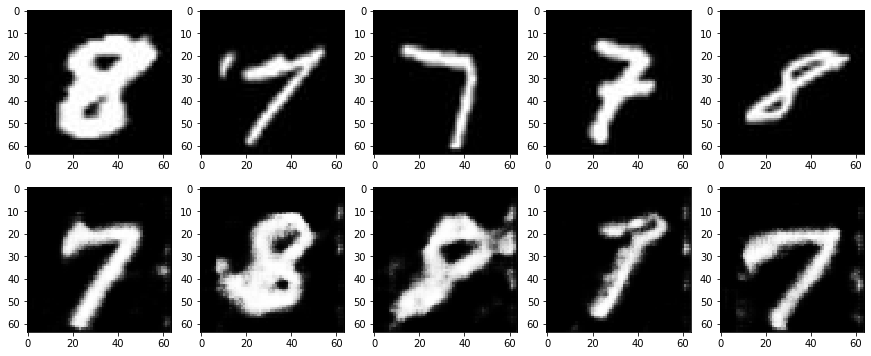

In [19]:
# 生成データ
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

# 本物データ
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

# 表示
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段は訓練データ
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段は生成データ
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

良い感じに手書き数字が出力されている  
epoch数を増やすと構造が単純でDを騙しやすい7ばっかり生成する  
このように教師データの一部しか生成しなくなる現象をモード崩壊と呼ぶ  
一般的に，GANの学習を安定的に行うのは難しいとされている